---
layout: single
title: "[C02 머신러닝 프로젝트 AtoZ]05 테스트 세트 샘플링"
categories: ml
tag: [python, ml]
toc: true
author_profile: false
typora-root-url: ../
sidebar:
  nav: "counts"
---


In [1]:
from functions import load_housing_data
housing = load_housing_data.load()

# 무작위 샘플링

## 무작위 샘플링 방법1) 
- data를 무작위로 섞은 다음 앞에서부터 test_ratio의 비율만큼 테스트 세트로 만든다.

In [2]:
import numpy as np

# 방법1) data를 무작위로 섞은 다음 앞에서부터 test_ratio의 비율만큼 테스트 세트로 만든다.
def split_train_test(data, test_ratio):
  # permutation() 함수는 0부터 len(data) - 1까지의 숫자를 무작위로 섞은 배열을 반환한다.
  shuffled_indices = np.random.permutation(len(data))
  # test_ratio만큼의 데이터 개수를 구한다.
  test_set_size = int(len(data) * test_ratio)

  # test_set_size만큼의 데이터를 test_indices에 저장하고, 나머지를 train_indices에 저장한다.
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  # iloc[] 메서드는 행 번호를 기준으로 행을 선택한다. indices에 저장된 행 번호에 해당하는 데이터를 반환한다.
  return data.iloc[train_indices], data.iloc[test_indices]

In [3]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train,", len(test_set), "test")

16512 train, 4128 test


### 방법 1의 문제와 해결
- 문제: 위 섞기를 반복하면, 머신러닝 알고리즘이 전체 데이터셋을 보게 됨: 이런 상황은 피해야 함
- 즉, 항상 똑같은 테스트 세트가 만들어지도록 해야 함.

- 해결1) 테스트 세트를 만들 때 저장하고 다음번 실행할 때는 처음 만들어둔 것을 이걸 불러와서 쓰는 것
- 해결2) 항상 같은 난수가 생각되도록 np.random.permutation()을 호출할 때 괄호 안에 난수 발생기 초깃값을 지정하는 것

- 그래도 문제: 데이터세트가 업데이트되면 index 번호가 늘어나 랜덤추출이 의미가 없어짐 항상 일괄적으로 같은 결과가 보장되어야 함

## 무작위 샘플링 방법2
- 각 샘플마다 고유한 식별자(id)를 가지고 이를 사용하기
- 예를 들어 행의 인덱스를 가지고, 마지막 인덱스의 20%에 해당하는 녀석들을 테스트로, 나머지는 훈련 세트로
- 각 인스턴스의 id로 해시값을 계산하고 해시값의 마지막 바이트 값이 51(256의 20%)보다 작거나 같은 경우만 테스트 세트로 보낸다.
- 이렇게 하면 데이터세트가 업데이트되어도 기존 훈련세트의 영향을 받지 않을 뿐더러, 새로 추가된 데이터세트에서도 일괄적으로 20%의 테스트 세트를 생성할 수 있다.

In [4]:
from zlib import crc32

# 각 인스턴스의 식별자를 사용하여 해시값을 계산하고 해시값의 마지막 바이트 값이 51(256의 20%)보다 작거나 같은 경우만 테스트 세트로 보낸다.
def test_set_check(identifier, test_ratio):
  # crc32() 함수는 데이터의 해시값을 계산한다.
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  # apply() 메서드는 각 행이나 열에 함수를 적용한다.
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [5]:
# 주택 데이터셋에는 id 컬럼이 없으므로 행의 인덱스를 ID로 사용한다.
housing_with_id = housing.reset_index()   # 'index' 열이 추가된 데이터프레임이 반환된다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### 행의 인덱스를 고유 식별자로 사용할 때 문제점
- 새 데이터는 데이터셋의 끝에 추가되어야 한다
- 어떤 행도 삭제되지 않아야 한다
- 이것이 불가능하다면 고유 식별자를 만드는데 안전한 특성을 사용해야 한다
- 예를 들어 위도와 경도는 바뀌지 않는 값이니, 이 두 값을 연결해서 ID를 만들 수 있다

In [6]:
# 행의 인덱스 대신 위도와 경도를 연결해 id값으로 써보자
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


## 무작위 샘플링 방법3
- sklearn의 train_test_split()을 사용하기

In [7]:
# 방법3) 사이킷런의 train_test_split() 함수를 사용한다.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# 지금까지 무작위 샘플링의 문제점

- 데이터셋이 충분히 크다면 문제가 없지만, 그렇지 않다면 샘플링 편향이 생김
- 예를 들어 설문조사시 1000명에게 질문을 하려면, 단순히 랜덤하게 1000명을 뽑는것이 아니라, 전체 인구를 대표할 수 있는 1000명을 선택하기 위해 노력해야 함

### 계층적 샘플링
- 전체 인구를 계층이라는 동질의 그룹으로 나누고, 테스트 세트가 전체를 대표하도록 각 계층에서 올바른 수의 샘플을 추출한다.
- 예를 들어 인구의 51.3%가 여성이라면, 샘플을 추출할때도 여성이 1000명의 샘플 중 513명이 되도록 하는 것

# 소득 카테고리를 잘 대표하는 샘플 뽑기
- 주택 가격을 예측하는데 소득이 중요하다고 판단(의뢰인이)했다면 - 소득 카테고리를 잘 대표할 수 있게 샘플을 뽑아야 한다
- 중간소득 히스토그램을 살펴보자
- 0부터 1.5 간격으로, 6 이상은 하나로 묶으면 적당할 것 같다

<Axes: >

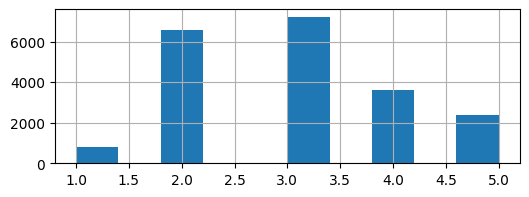

In [10]:
import pandas as pd

# 계층적 샘플링: 0부터 1.5 간격으로, 6 이상은 하나로 묶자.
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist(
  figsize=(6, 2)
)

In [12]:
# StratifiedShuffleSplit은 StratifiedKFold의 계층적 샘플링과 ShuffleSplit의 무작위 샘플링을 합친 것이다.
from sklearn.model_selection import StratifiedShuffleSplit

# 계층적 샘플링을 사용하여 훈련 세트와 테스트 세트를 나눈다.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

print(len(train_index), train_index)
print(len(test_index), test_index)

16512 [12655 15502  2908 ... 19263 19140 19773]
4128 [ 5241 17352  3505 ... 17223 10786  3965]


In [13]:
# 각 계층마다 테스트 세트에 있는 데이터의 비율을 계산한다.
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [14]:
# income_cat 특성은 샘플링을 위해 임시로 만든 것이므로, 삭제해서 데이터를 원상태로 되돌리겠음
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [15]:
# 다음 파일에서 작업을 이어서 하기 위해 strat_train_set를 csv로 일단 저장하자!
strat_train_set.to_csv("../datasets/temp/strat_train_set.csv")
strat_test_set.to_csv("../datasets/temp/strat_test_set.csv")